In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans

from functions import *


In [24]:
def load_series(directory):
    """Loads every csv file from given directory. Assumes each contains two coulumns, first with date, second
    with the variable, without headers, and that name of the variable and of the place is contained in the name
    of the file in the form place_variable.csv."""
    dataframes_dict = {}
    files = os.listdir(directory)
    # Import each file as a separate DataFrame and assign headers
    for file_name in files:
        if file_name.endswith('.csv'):  # Check if the file is a CSV file
            # Extract headers from the filename by splitting it by "_"
            headers = file_name.split("_")
            header = "_".join(headers[1:])
            header = header.split(".")[0]
            header = "_".join(header.split(" "))
            headers = ["date", header]

            # Read the CSV file into a DataFrame, specifying column names as headers
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path, header=None, names=headers, sep=";")
            df["date"] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
    
            # Store the DataFrame in the dictionary with the filename as the key
            dataframes_dict[file_name] = df
    return dataframes_dict

In [25]:
def merge_site_data(dataframes_dict):
    sites = set(file.split("_")[0] for file in dataframes_dict.keys())
    site_dataframes = {}
    
    for site in sites:
        df = pd.DataFrame(columns=['date'])
        for file in dataframes_dict.keys():
            if file.startswith(site):
                site_df = dataframes_dict[file]
                df = pd.merge(df, site_df, on='date', how='outer')
        site_dataframes[site] = df
    return site_dataframes

In [26]:
def join_data(datas_dictionary):
    for site in datas_dictionary:
        datas_dictionary[site]["site"] = site
    result = pd.concat(list(datas_dictionary.values()), join='outer', ignore_index=True)
    return result

In [27]:
def clean_data(datas_dictionary, main_var = "prutok_computed"):
    cleaned_datas = {}
    for site in datas_dictionary:
        df = datas_dictionary[site]
        df = df.dropna(subset=[main_var])
        cleaned_datas[site] = df
    return cleaned_datas

In [28]:
class TS_Class:
    
    def __init__(self, data, main_var = "Prietok", 
                 start_date = None, end_date = None, periodicity = "2T", check_per = True):
        if start_date is None:
            start_date = data["date"].min()
        self.start_date = start_date
        if end_date is None:
            end_date = data["date"].max()
        self.end_date = end_date
        self.periodicity = periodicity
        
        self.data = data
        if check_per:       # ensuring we have constant periodicity in observations
            self.enforce_periodicity(start_date, end_date, periodicity)
        
        self.main_var = main_var
        self.data[main_var + "_diff_1"] = data[main_var].diff()
        self.data[main_var + "_diff_2"] = self.data[main_var + "_diff_1"].diff()
        self.models = {}
    
    def enforce_periodicity(self, start_date = None, end_date = None, periodicity = None):
        if start_date is None: start_date = self.start_date
        if end_date is None: end_date = self.end_date
        if periodicity is None: periodicity = self.periodicity
        date_range = pd.date_range(start=start_date, end=end_date, freq=periodicity)
        df = pd.DataFrame({'date': date_range})
        self.data = df.merge(self.data, on='date', how='left')   # ensuring we have constant periodicity in observations
    
    def get_period_data(self, period, start_time = None, which = 1, subset = None):
        """Period is either 'daily', 'weekly', or whole number indicating number of hours."""
        used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
        if type(period) == int:
            if start_time is None or start_time == "start":
                reference_point = used_data["date"].min()
            else:
                start_time = datetime.strptime(start_time, "%H:%M:%S")
                reference_point = used_data[used_data['date'].dt.time == start_time.time()]["date"].min()
                used_data = used_data[used_data["date"]>= reference_point]    # cut off observations before start_time
            used_data["period_index"] = used_data["date"].apply(lambda x: (x-reference_point).total_seconds() // (period * 3600))
            used_data["period_name"] = used_data["period_index"].apply(
                lambda x:f"[{reference_point + timedelta(hours=period*x)} -- {reference_point + timedelta(hours=period*(x+1))})")
        
        elif period == "daily":
            used_data['period_name'] = used_data['date'].dt.date
            
        elif period == "weekly":
            first = used_data['date'].dt.strftime('%Y-%W').apply(
                lambda x: x.split("-")).apply(
                lambda y: datetime.strptime(f'{y[0]}-W{y[1]}-1', "%Y-W%U-%w") )
            used_data['period_name'] = first.apply(
                lambda x: f"{x.strftime('%Y-%m-%d')} -- {(x+timedelta(days=6)).strftime('%Y-%m-%d')}")
                       
        else:
            raise NameError('Period which is not recognized have been entered. "weekly" or "daily" are expected.')
        
        if which == 1:
            self.period_data = used_data.groupby('period_name')
        else:
            self.period_data_2 = used_data.groupby('period_name')
        
    def get_y_lim(self, value, negative = False):
        if negative:
            value = - value
        if value < 0.05: return value*1.1
        if value < 0.09: return 0.1
        if value < 0.47: return 0.5
        if value < 0.9: return 1
        if value < 2.45: return 2.5
        if value < 4.9: return 5
        if value < 9.5: return 10
        if value < 19: return 20
        return value*1.1
    
    def get_rob_subset(self, variable, rob_quantile, two_sided):
        subset = self.data[variable] < self.data[variable].quantile(rob_quantile)
        if two_sided:
            L = self.data[variable].quantile(1-rob_quantile)
            U = self.data[variable].quantile(rob_quantile)
            subset =  self.data[variable].apply(lambda x: L<x<U)
        return subset
    
    def get_measures(self, variable, include, window, which = 1, 
                     quantile = 0.5, rob_quantile = 0.8, two_sided_rob_q = False, rob_q_mult = 1):   
        suff = "" if which == 1 else "_2"
        if two_sided_rob_q:
            rob_quantile = 0.5 + rob_quantile/2
        if "CMA" in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
        if ("CMA_bounds" in include) or ("CMA_bounds_2sd" in include):
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
            self.data['CMA_upper'+suff] = self.data['Centered_Moving_Average'+suff] + self.data['Centered_Moving_SD'+suff]
            self.data['CMA_lower'+suff] = self.data['Centered_Moving_Average'+suff] - self.data['Centered_Moving_SD'+suff]
            if "CMA_bounds_2sd" in include:
                self.data['CMA_upper_2sd'+suff] = self.data['Centered_Moving_Average'+suff] + 2*self.data['Centered_Moving_SD'+suff]
                self.data['CMA_lower_2sd'+suff] = self.data['Centered_Moving_Average'+suff] - 2*self.data['Centered_Moving_SD'+suff]
        if "CMA_rob_bounds"  in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()
            self.data['CMA_upper_rob'+suff] = self.data['Centered_Moving_Average'+suff] + rob_q_mult*robust_sd
            self.data['CMA_lower_rob'+suff] = self.data['Centered_Moving_Average'+suff] - rob_q_mult*robust_sd
                
        if "MA" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
        if ("MA_bounds" in include) or ("MA_bounds_2sd" in include):
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
            self.data['MA_upper'+suff] = self.data['Moving_Average'+suff] + self.data['Moving_SD'+suff]
            self.data['MA_lower'+suff] = self.data['Moving_Average'+suff] - self.data['Moving_SD'+suff]
            if "MA_bounds_2sd" in include:
                self.data['MA_upper_2sd'+suff] = self.data['Moving_Average'+suff] + 2*self.data['Moving_SD'+suff]
                self.data['MA_lower_2sd'+suff] = self.data['Moving_Average'+suff] - 2*self.data['Moving_SD'+suff]
        if "MA_rob_bounds" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            robust_sd = self.data[subset][variable].std()
            self.data['MA_upper_rob'+suff] = self.data['Moving_Average'+suff] + rob_q_mult*robust_sd
            self.data['MA_lower_rob'+suff] = self.data['Moving_Average'+suff] - rob_q_mult*robust_sd
        
        if "CMSD" in include:
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
        if "MSD" in include:
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
        if "tot_avg" in include:
            self.data['total_avg'+suff] = self.data[variable].mean()
        if "quant" in include:
            self.data['quantile'+suff] = self.data[variable].quantile(quantile)
        if "robust_avg" in include:
            subset = self.get_rob_subset(variable, rob_quantile, two_sided_rob_q)
            self.data['r_avg'+suff] = self.data[subset][variable].mean()
            
    
    def get_ax(self, ax, group_data, unit, variable, include, rain_lims, which, include_rain = True, marker = None):  
        suff = "" if which == 1 else "_2"
        ax.plot(group_data['date'], group_data[variable], label = variable)
        include_c = include.copy()   
        if "CMA" in include_c:
            ax.plot(group_data['date'], group_data['Centered_Moving_Average'+suff], color="red", label = "CMA")
            include_c.remove("CMA")
        
        if "CMA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper_2sd'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower_2sd'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds_2sd")
        if "CMA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower'+suff], color="orange", label = "CMA_L")
            include_c.remove("CMA_bounds")
        
        if "CMA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['CMA_upper_rob'+suff], color="black", label = "CMA_rob_Up")
            ax.plot(group_data['date'], group_data['CMA_lower_rob'+suff], color="black", label = "CMA_rob_L")
            include_c.remove("CMA_rob_bounds")
            
        if "MA" in include_c:
            ax.plot(group_data['date'], group_data['Moving_Average'+suff], color="brown", label = "MA")
            include_c.remove("MA")
        if "MA_bounds" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds")
        if "MA_bounds_2sd" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper_2sd'+suff], color="yellow", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower_2sd'+suff], color="yellow", label = "MA_L")
            include_c.remove("MA_bounds_2sd")
        if "MA_rob_bounds" in include_c:
            ax.plot(group_data['date'], group_data['MA_upper_rob'+suff], color="black", label = "MA_rob_Up")
            ax.plot(group_data['date'], group_data['MA_lower_rob'+suff], color="black", label = "MA_rob_L")
            include_c.remove("MA_rob_bounds")
            
        if "CMSD" in include_c:
            ax.plot(group_data['date'], group_data['Centered_Moving_SD'+suff], color="green", label = "CMSD")
            include_c.remove("CMSD")
        if "MSD" in include_c:
            ax.plot(group_data['date'], group_data['Moving_SD'+suff], color="black", label = "MSD")
            include_c.remove("MSD")
        if "tot_avg" in include_c:
            ax.plot(group_data['date'], group_data['total_avg'+suff], color="black", label = "tot_avg")
            include_c.remove("tot_avg")
        if "quant" in include_c:
            ax.plot(group_data['date'], group_data['quantile'+suff], color="black", label = "quantile")
            include_c.remove("quant")
        if "robust_avg" in include_c:
            ax.plot(group_data['date'], group_data['r_avg'+suff], color="black", label = "robust_avg")
            include_c.remove("robust_avg")
        
        max_y = group_data[variable].max()
        min_y = group_data[variable].min()
        #print(variable+str(min_y))    #########
        #print(variable+str(max_y))    #########
        #print(variable+" no-nan "+str(max_y))    #########
        for item in include_c:
            if item in group_data.columns:
                ax.plot(group_data['date'], group_data[item], label = item)
                max_y = max(max_y, group_data[item].max())
                min_y = min(min_y, group_data[item].min())
                #print(item+str(min_y))    #########
               # print(item+str(max_y))    #########
                        
        ax.set_title(f'Time Series for {unit}')
        ax.set_xlabel('Date and Time')
        ax.set_ylabel(variable)
        ax.legend(loc="upper left")
        ylim_up = self.get_y_lim(max_y)
        ylim_down = -self.get_y_lim(min_y, True) if min_y < 0 else 0
 #       print("down "+str(ylim_down))            ##############
 #       print("up "+str(ylim_up))
        try:
            ax.set_ylim(ylim_down, ylim_up)
        except:
            print("down "+str(ylim_down))            ##############
            print("up "+str(min_y))
        for line in ax.lines:
            line.set_marker(marker)
            
        if include_rain:
            ax2 = ax.twinx()
            ax2.set_ylim(*rain_lims)
            ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
            ax2.invert_yaxis()
            ax2.set_ylabel('rain (Upside-Down)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')
            return (ax, ax2)
        return (ax, "")
        
    def plot(self, variable = None, period = "all", start_time = None, subset = None, 
             quantile = 0.5, rob_quantile = 0.8, two_sided_rob_q = False, rob_q_mult = 1,
             include = ["CMA", "CMA_bounds"], window = 30, rain_lims = (0,5), fig_size = None, 
            variable_2 = None, start_time_2 = None, include_2 = ["CMA", "CMA_bounds"], window_2 = 30, 
            quantile_2 = 0.5, rob_quantile_2 = 0.8, two_sided_rob_q_2 = False, rob_q_mult_2 = 1, 
             double_plot = False, include_rain = True, marker = None):
        if variable is None:
            variable = self.main_var
        
        self.get_measures(variable, include, window, which = 1, quantile = quantile, rob_quantile = rob_quantile, 
                          two_sided_rob_q = two_sided_rob_q, rob_q_mult = rob_q_mult)
        if start_time_2 is not None:
            if variable_2 is None: variable_2 = variable
            self.get_measures(variable_2, include_2, window_2, which = 2, quantile = quantile_2, 
                              rob_quantile = rob_quantile_2, two_sided_rob_q = two_sided_rob_q_2, rob_q_mult = rob_q_mult_2)
                
        if period == "all":
            self.data["const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.period_data = used_data.groupby("const")
        else:
            self.get_period_data(period, start_time, 1, subset)
        
        if start_time_2 is None:
            self.period_data_2 = self.period_data
        else:
            if period == "all":
                self.data["const"] = "whole data"
                used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
                self.period_data_2 = used_data.groupby("const")
            else:
                self.get_period_data(period, start_time_2, 2, subset)
            
        for grouped_1, grouped_2 in zip(self.period_data,self.period_data_2):
            unit_1, group_data_1 = grouped_1
            unit_2, group_data_2 = grouped_2
            
            if double_plot:
                group_data_1.set_index('date', inplace=True)
                group_data_2.set_index('date', inplace=True)
                group_data_1[variable].plot(xlabel = 'Date and Time', ylabel = variable, label = variable)
                group_data_2[variable_2].plot(label = variable_2)
                
                plt.title(f'Time Series for {unit_1}')
                plt.legend(loc="upper left")
                plt.show()
                continue
            
            if start_time_2 is not None:
                if fig_size is None: 
                    fig_size = (19, 6)
                fig, ax = plt.subplots(1, 2, figsize=fig_size)
                ax[0], axb1 = self.get_ax(ax[0], group_data_1, unit_1, variable, include, rain_lims, 1, include_rain, marker)
                ax[1], axb2 = self.get_ax(ax[1], group_data_2, unit_2, variable_2, include_2, rain_lims, 2, include_rain, marker)
            else:
                if fig_size is None: 
                    fig_size = (10, 6)
                fig, ax = plt.subplots(figsize=fig_size)
                ax, axb1 = self.get_ax(ax, group_data_1, unit_1, variable, include, rain_lims, 1, include_rain, marker)
            plt.grid(True)
            plt.show()
            
    def groupby(self, groupby):
        if groupby is None:
            self.data["const"] = "whole data"
            grouped = self.data.groupby("const")
        else:
            if groupby == "daily":
                self.data['period_name'] = self.data['date'].dt.date
                grouped = self.data.groupby("period_name")
            elif groupby == "weekly":
                self.data['period_name'] = self.data['date'].dt.strftime('%Y-%W')
                grouped = self.data.groupby("period_name")
            else:
                grouped = self.data.groupby(groupby)
        return grouped
    
    def get_ETS(self, variable, model_name, groupby = None, show_progress = True,
                error="add", trend="add", seasonal="add", damped_trend=False, seasonal_periods=720):
        """Note: there is 720 observations per day, for 1 day periodicity we need 720 seasonal components, which is too 
        many for practical estimatation - careful about seasonal components."""
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)
                        
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ETSModel(grouped_data[variable], error=error, trend=trend, seasonal=seasonal, 
                                            damped_trend=damped_trend, seasonal_periods=seasonal_periods)
            result = model.fit()
            grouped_data[model_name + "_fitted"] = result.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def get_ARIMA(self, p, d, q, model_name, variable = None,  groupby = None, show_progress = True):
        if variable is None: variable = self.main_var
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        grouped = self.groupby(groupby)           
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ARIMA(grouped_data[variable], order=(p, d, q))
            results = model.fit()
            grouped_data[model_name + "_fitted"] = results.fittedvalues
            self.models[model_name].append((unit, model, results))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length} ({(i+1)*100/length}%)")
                    
    def ARIMA_diagnostics(self, results, unit, model_name, show_summary = True):
        print("ARIMA diagnostics for " + model_name + " " + str(unit))
        if show_summary:
            print(results.summary())
        residuals = results.resid
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax[0, 0].plot(residuals)
        ax[0, 0].set_title('Residuals')
        lags_1 = min(40, len(residuals)-1)
        lags_2 = min(40, int(len(residuals)/2)-2)
        sm.graphics.tsa.plot_acf(residuals, lags=lags_1, ax=ax[0, 1])
        sm.graphics.tsa.plot_pacf(residuals, lags=lags_2, ax=ax[1, 0])
        plt.show()

        # Ljung-Box test for autocorrelation in residuals
        acf, q_val, p_val = sm.tsa.acf(residuals, fft=True, qstat=True)
        p_val_df = pd.DataFrame({'Lag': range(1, len(p_val) + 1), 'P-Value': p_val})

        print(p_val_df)
    
    def ARIMAs_diagnostics(self, model_name, subset = None):
        models = self.models[model_name]
        if subset is not None:
            models = models[subset]
        for unit, mod, res in models:
            self.ARIMA_diagnostics(res, unit, model_name)
            
    def get_time_trend(self, values, give = "slope"):
        """Values should have a data series format with specified index which represents time order."""
        X = sm.add_constant(values.index)
        model = sm.OLS(values, X).fit()
        if give == "slope":
            return model.params[1]
        if give == "constant":
            return model.params[0]
        if give == "model":
            return model
        
     ##Inserted by SP
    def get_cycl_adj(self, weekdays = True,  var = None, ext_fit = False, fit = None, return_fit = False):
        """Create cyclically adjusted features based on hour of the day and the day of the week"""
        if var == None:
            var = self.main_var
        if ext_fit & (fit==None):
            raise ValueError("If the external fit is chosen, the fit needs to be given")
        
        if not ext_fit:
            self.data = cyclical_adj_full(self.data, weekdays, var, return_fit)
        else:
            self.data = cyclical_adj_external(self.data, fit, var)

In [29]:
class Data_Explorer:
    
    def __init__(self, datas_dictionary, main_vars = None, 
                 start_dates = None, end_dates = None, periodicities = None, check_pers = None):
        datas_dictionary = {site: datas_dictionary[site] for site in sorted(datas_dictionary)}  # sort dictionary by keys
        self.data_dict = datas_dictionary
        self.sites = list(datas_dictionary.keys())
        self.joined_data = join_data(datas_dictionary)
        
        if main_vars is None: main_vars = {site: "prutok_computed" for site in self.sites}
        if start_dates is None: start_dates = {site: None for site in self.sites}
        if end_dates is None: end_dates = {site: None for site in self.sites}
        if periodicities is None: periodicities = {site: "2T" for site in self.sites}
        if check_pers is None: check_pers = {site: True for site in self.sites}
                
        self.TS_objects = {site: TS_Class(
            datas_dictionary[site], main_var = main_vars[site] 
            , start_date = start_dates[site], end_date = end_dates[site]
            , periodicity = periodicities[site], check_per = check_pers[site])
                          for site in self.sites}
        
        self.TS_objects["joined"] = TS_Class(self.joined_data, main_var = main_vars[self.sites[0]]
                                            , start_date = start_dates[self.sites[0]], end_date = end_dates[self.sites[0]]
                                            , periodicity = periodicities[self.sites[0]], check_per = False)
        self.sites.append("joined")
        self.data_dict["joined"] = self.joined_data
        self.main_vars = {site: self.TS_objects[site].main_var for site in self.sites}
        self.start_dates = {site: self.TS_objects[site].start_date for site in self.sites}
        self.end_dates = {site: self.TS_objects[site].end_date for site in self.sites}
        self.periodicities = {site: self.TS_objects[site].periodicity for site in self.sites}

In [42]:

path = ".\dhi_data2"

In [43]:
files = os.listdir(path)

In [44]:
files

['MP1_hladina_result.csv',
 'MP1_hladina_TL_zdroj.csv',
 'MP1_hladina_UZ_zdroj.csv',
 'MP1_prutok_computed.csv',
 'MP1_rychlost_result.csv',
 'MP1_rychlost_zdroj.csv',
 'MP2_hladina_result.csv',
 'MP2_hladina_TL_zdroj.csv',
 'MP2_hladina_UZ_zdroj.csv',
 'MP2_prutok_computed.csv',
 'MP2_rychlost_result.csv',
 'MP2_rychlost_zdroj.csv',
 'MP3_hladina TL_zdroj.csv',
 'MP3_hladina UZ_zdroj.csv',
 'MP3_hladina_result.csv',
 'MP3_prutok_computed.csv',
 'MP3_rychlost_result.csv',
 'MP3_rychlost_zdroj.csv',
 'MP4_hladina TL_zdroj.csv',
 'MP4_hladina UZ_zdroj.csv',
 'MP4_hladina_result.csv',
 'MP4_prutok_computed.csv',
 'MP4_rychlost_result.csv',
 'MP4_rychlost_zdroj.csv',
 'MP5_hladina_result.csv',
 'MP5_hladina_UZ_zdroj.csv',
 'MP5_prutok_computed.csv',
 'MP5_rychlost_result.csv',
 'MP5_rychlost_zdroj.csv',
 'MP6_hladina TL_zdroj.csv',
 'MP6_hladina UZ_zdroj.csv',
 'MP6_hladina_result.csv',
 'MP6_prutok_computed.csv',
 'MP6_rychlost_result.csv',
 'MP6_rychlost_zdroj.csv',
 'MP7_hladina TL_zdro

In [33]:
dataframes_dict = load_series(path)

In [34]:
site_dataframes = merge_site_data(dataframes_dict)
site_dataframes = clean_data(site_dataframes)

In [45]:
first_data = pd.read_csv(".\Q01_HL_23.csv", skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "prutok_computed"],
                  sep = ";", decimal=',')

rain = pd.read_csv(".\SR02_H2_27374.csv", skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

first_data["date"] = pd.to_datetime(first_data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

rain["date"] = rain.index
rain.index = range(rain.shape[0])
first_data = first_data.merge(rain, on='date', how='left')

In [46]:
site_dataframes["first"] = first_data

In [37]:
explorer = Data_Explorer(site_dataframes)

In [38]:
explorer.joined_data.describe()

,date,hladina_result,hladina_TL_zdroj,hladina_UZ_zdroj,prutok_computed,rychlost_result,rychlost_zdroj,Hl-Vega-OK,Hladina KDO,Teplota KDO,Rychlost KDO,Prietok_l,rain,rain_2m,prutok_computed_diff_1,prutok_computed_diff_2
count,536136,513775.000000,427286.000000,498851.000000,536136.000000,513799.000000,500979.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,1304.000000,5484.000000,536135.000000,5.361340e+05
mean,2021-11-17 04:15:40.004587520,0.175209,0.207547,0.174599,0.237282,0.727235,0.698849,185.552310,192.835476,15.688517,0.263786,29.987177,0.050613,0.023359,0.000010,-9.188748e-07
min,2019-07-25 15:03:00,0.004760,0.000000,0.000000,0.000000,0.000000,-0.670000,0.000000,100.000000,13.000000,-0.090000,0.000000,0.000000,0.000000,-26.420000,-2.855000e+01
25%,2021-04-30 10:57:30,0.078000,0.109000,0.079000,0.006100,0.391320,0.336000,157.000000,139.000000,15.000000,0.160000,12.800000,0.000000,0.000000,-0.000800,-9.500000e-04
50%,2022-01-25 05:59:00,0.172780,0.216000,0.179000,0.096730,0.644260,0.640000,170.000000,180.000000,16.000000,0.270000,21.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,2022-08-22 19:28:15,0.270500,0.287000,0.272000,0.147300,1.094490,1.060000,182.000000,221.000000,16.000000,0.350000,34.100000,0.100000,0.000000,0.000730,9.900000e-04
max,2023-02-25 02:32:00,2.719660,2.720000,1.337000,39.150000,3.407220,3.736000,794.000000,970.000000,19.000000,0.800000,326.300000,1.700000,3.300000,17.770000,3.588000e+01
std,NaN,0.114385,0.103362,0.117226,1.108728,0.423903,0.444343,77.118763,91.678332,0.995117,0.113476,34.873107,0.132684,0.128841,0.198879,3.108858e-01


In [39]:
sites = explorer.sites

In [40]:
sites

['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'MP7', 'first', 'joined']

ValueError: Unrecognized marker style None

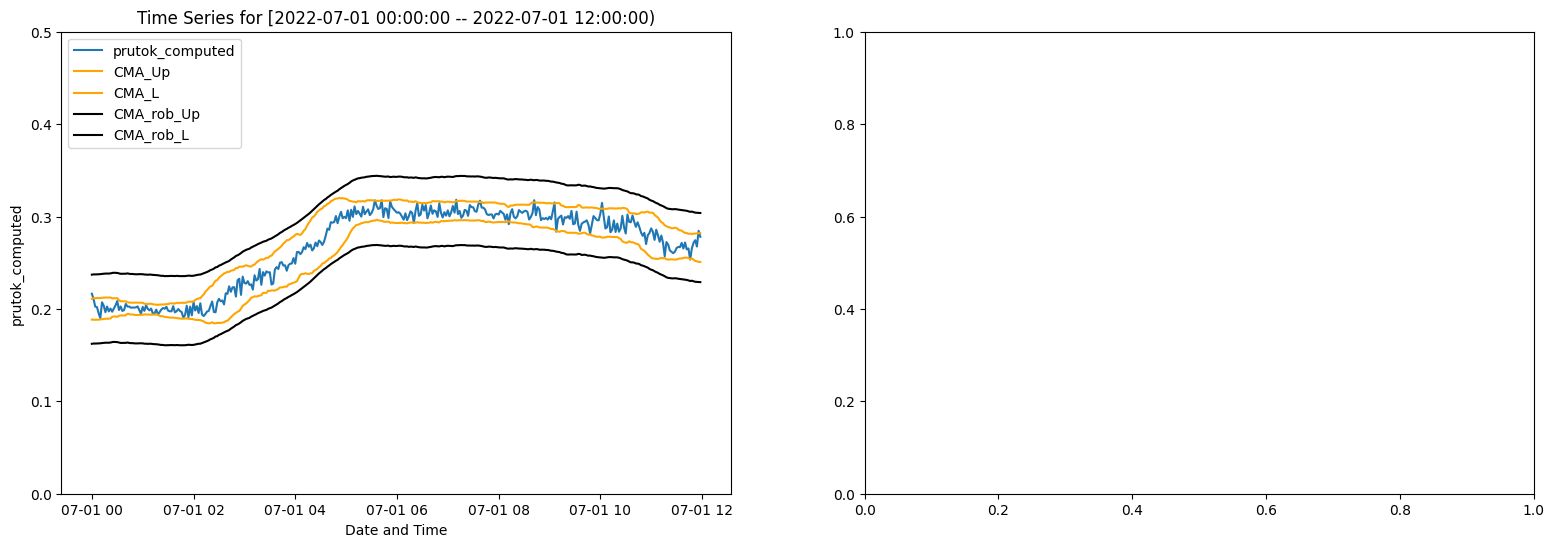

In [41]:
explorer.TS_objects['MP1'].plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"], include_rain = False)

In [ ]:
explorer.TS_objects['MP5'].plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"], include_rain = False)

In [ ]:
i=-1

In [ ]:
i+=1
site_dataframes[sorted(site_dataframes.keys())[i]]

,date,hladina_result,hladina_TL_zdroj,hladina_UZ_zdroj,prutok_computed,rychlost_result,rychlost_zdroj
0,2022-06-30 13:12:00,0.3190,0.304,0.320,0.30855,1.28000,1.31
1,2022-06-30 13:14:00,0.3205,0.309,0.315,0.31119,1.28250,1.26
2,2022-06-30 13:16:00,0.3180,0.306,0.314,0.30870,1.28628,1.31
3,2022-06-30 13:18:00,0.3165,0.308,0.317,0.30740,1.28941,1.27
4,2022-06-30 13:20:00,0.3165,0.309,0.317,0.30778,1.29097,1.35
...,...,...,...,...,...,...,...
99332,2022-06-30 12:12:00,NaN,NaN,NaN,NaN,1.05371,NaN
99333,2022-06-30 12:26:00,NaN,NaN,NaN,NaN,1.05203,NaN
99334,2022-06-30 12:30:00,NaN,NaN,NaN,NaN,1.02264,NaN
99335,2022-06-30 12:56:00,NaN,NaN,NaN,NaN,1.28544,NaN


In [ ]:
for site in sorted(site_dataframes.keys()):
    print(site)
    df = site_dataframes[site]
    print(df.shape)
    print(site + " NAs:")
    print(df.isna().sum())
    print(f"{site} from {df['date'].min()} to {df['date'].max()}")
    print(site + " observation intervals:")
    print(df['date'].diff().dropna().value_counts())
    print(df["prutok_computed"].describe())

MP1
(99337, 7)
MP1 NAs:
date                    0
hladina_result      18865
hladina_TL_zdroj      371
hladina_UZ_zdroj      386
prutok_computed     18865
rychlost_result     18794
rychlost_zdroj        371
dtype: int64
MP1 from 2022-06-30 11:08:00 to 2022-10-20 08:16:00
MP1 observation intervals:
0 days 00:02:00        99290
0 days 00:01:00           34
0 days 00:04:00            3
0 days 00:03:00            1
0 days 00:06:00            1
0 days 00:12:00            1
-1 days +23:12:00          1
0 days 00:14:00            1
0 days 00:26:00            1
-112 days +03:34:00        1
-112 days +04:44:00        1
85 days 16:49:00           1
Name: date, dtype: int64
count    80472.000000
mean         0.184037
std          0.127910
min          0.052010
25%          0.125930
50%          0.163455
75%          0.196762
max          1.745810
Name: prutok_computed, dtype: float64
MP2
(66257, 7)
MP2 NAs:
date                   0
hladina_result         3
hladina_TL_zdroj    2092
hladina_UZ_zdroj

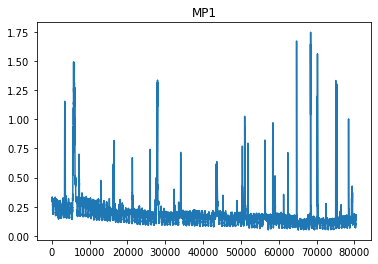

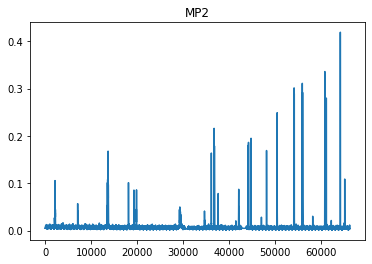

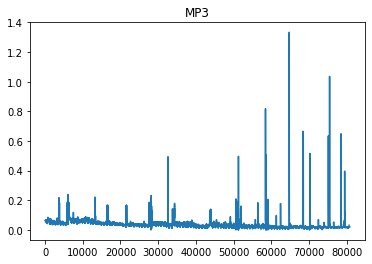

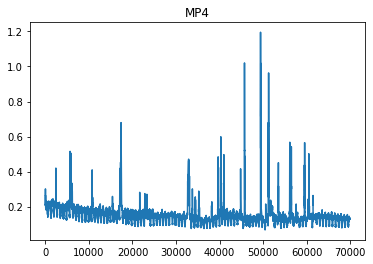

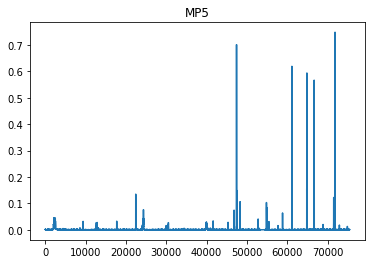

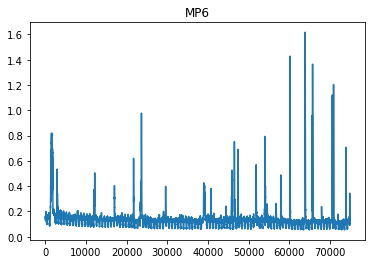

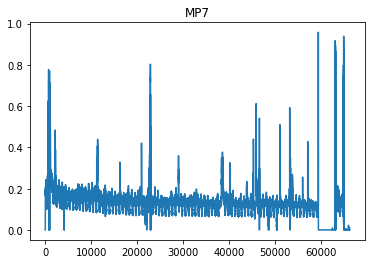

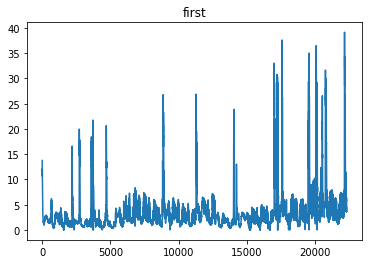

In [ ]:
for site in sorted(site_dataframes.keys()):
    df = site_dataframes[site]
    df["prutok_computed"].plot(title = site)
    plt.show()
    plt.close()